In [92]:
import torch
print(torch.cuda.is_available())

# https://www.kaggle.com/datasets/footballjoe789/us-stock-dataset/data


from torch import nn as nn
from torch.nn import functional as F

from transformer_common import GeluFeedForward, TransformerConfig, \
    PositionalEmbedding, DistancePositionalEmbedding, AbstractModel, RMSNorm, \
    LinearFeedForward, plot_timeseries, scale_timeseries_data, \
    filter_invalid_stocks, GenericModelRunner, GenericDataloader


class Block(nn.Module):
    def __init__(self, config:TransformerConfig, attention_provider:lambda:nn.Module):
        super().__init__()
        self.l_norm1 = RMSNorm(config.n_embed)
        self.attention = attention_provider()
        self.l_norm2 = RMSNorm(config.n_embed)
        self.ffwd = GeluFeedForward(config.n_embed, config.hidden_size, config.n_embed, config.dropout, bias=False)

    def forward(self, x):
        x = x + self.attention(self.l_norm1(x))
        x = x + self.ffwd.forward(self.l_norm2(x))
        return x

class BlockSequence(nn.Module):
    def __init__(self, config:TransformerConfig, attention_provider:lambda:nn.Module):
        super().__init__()
        self.blocks = nn.Sequential(*[Block(config, attention_provider) for _ in range(config.n_layer)])

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x

    
class TorchMultiHeadAttention(nn.Module):
    # https: // pytorch.org / docs / stable / generated / torch.nn.functional.scaled_dot_product_attention.html
    def __init__(self, config):
        super().__init__()

        num_heads = config.n_head
        embed_dimension = config.n_embed
        is_causal = config.causal
        dropout = config.dropout
        bias = False

        assert embed_dimension % num_heads == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(embed_dimension, 3 * embed_dimension, bias=bias)
        # output projection
        self.c_proj = nn.Linear(embed_dimension, embed_dimension, bias=bias)
        # regularization
        self.dropout = dropout
        self.resid_dropout = nn.Dropout(dropout)
        self.num_heads = num_heads
        self.embed_dimension = embed_dimension
        # Perform causal masking
        self.is_causal = is_causal

    def forward(self, x):
    
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        query_projected = self.c_attn(x)

        batch_size = query_projected.size(0)
        embed_dim = query_projected.size(2)
        head_dim = embed_dim // (self.num_heads * 3)

        query, key, value = query_projected.chunk(3, -1)
        query = query.view(batch_size, -1, self.num_heads, head_dim).transpose(1, 2)
        key = key.view(batch_size, -1, self.num_heads, head_dim).transpose(1, 2)
        value = value.view(batch_size, -1, self.num_heads, head_dim).transpose(1, 2)

        # Apply attention with modified scores
        if self.training:
            dropout = self.dropout
            is_causal = self.is_causal
        else:
            dropout = 0.0
            is_causal = False

        y = F.scaled_dot_product_attention(query, key, value, attn_mask=None, dropout_p=dropout,
                                           is_causal=is_causal)

        y = y.transpose(1, 2).view(batch_size, -1, self.num_heads * head_dim)

        y = self.resid_dropout(self.c_proj(y))
        return y


class TorchTransformerModel(AbstractModel):
    def __init__(self, config):
        super().__init__(config)
        # self.pos_emb1 = PositionalEmbedding(config)
        self.ffwd1 = GeluFeedForward(config.input_embed, config.hidden_size, config.n_embed, config.dropout, bias=True)
        self.t1 = BlockSequence(config, lambda: TorchMultiHeadAttention(config))
        self.ffwd2 = GeluFeedForward(config.n_embed, config.hidden_size, config.output_embed, config.dropout, bias=True)

    def forward(self, inp):
        x = inp
        b, t, c = x.shape
        x = self.ffwd1(x)
        # pos_emb = self.pos_emb1(b, t)
        x = self.t1(x)
        x = self.ffwd2(x)
        return x



False


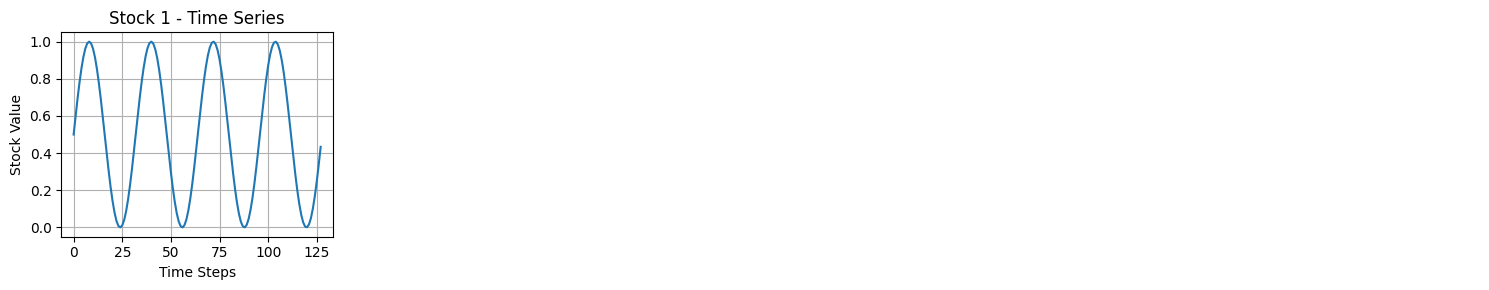

In [93]:
import math

my_device = 'mps'
# my_device = 'cpu'

# Parameters
n = 128  # Number of data points
num_of_channels = 1   

# Generate a time series of n points
t = torch.linspace(0, math.pi * n // 16, n)

# Generate sine values for the batch
sin_values = torch.sin(t).unsqueeze(1).repeat(1, num_of_channels).transpose(0,1)

sin_values = (sin_values + 1) / 2  # [0, 1]

plot_timeseries(sin_values, num_charts=1)

data = sin_values.to(my_device)

In [94]:
print(data.shape)

data = filter_invalid_stocks(data)
print(f"shape after filtering {data.shape}")

torch.Size([1, 128])
shape after filtering torch.Size([1, 128])


In [95]:
data.shape

torch.Size([1, 128])

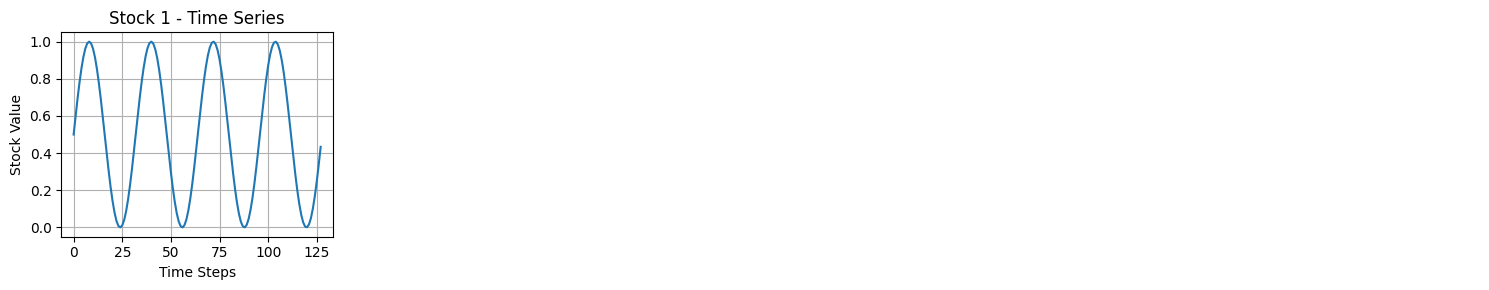

In [96]:
# Plotting the first 5 stocks' time-series data
plot_timeseries(data, num_charts=10)

In [97]:
# data = torch.diff(data, dim=1)
scaled_data = scale_timeseries_data(data, dim=1)  # Scale each stock independently
scaled_data.shape

torch.Size([1, 128])

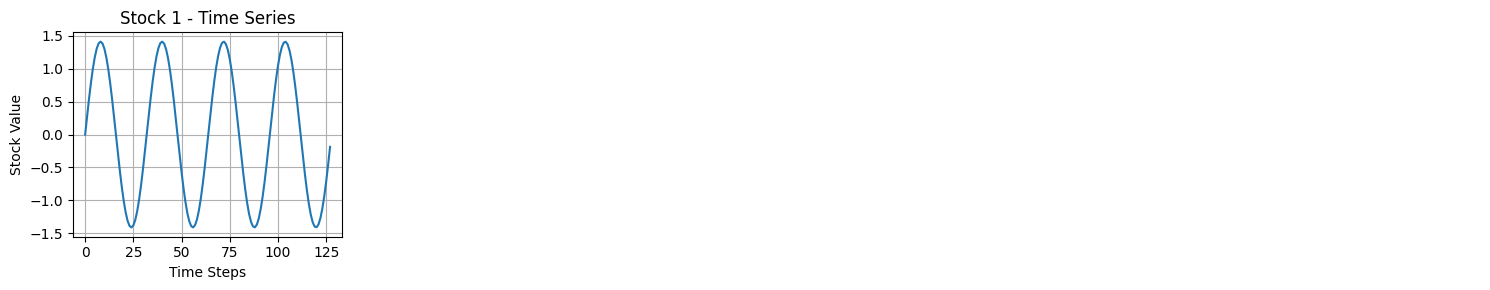

In [98]:
plot_timeseries(scaled_data, num_charts=10)

In [99]:
# data_diff = data.diff(dim=1)

In [100]:
data.shape

torch.Size([1, 128])

In [101]:
num_of_channels=1

back_window=32
pred_ahead=32
vocab_size=100

clean_data = scaled_data[0:num_of_channels,1:].transpose(0, 1)
print(clean_data.shape)

torch.Size([127, 1])


In [102]:
inp_clean_data=clean_data[:-pred_ahead,:].unfold(dimension=0, size=back_window, step=1)
print(inp_clean_data.shape)
inp_clean_data=inp_clean_data.reshape(inp_clean_data.shape[0], -1)
inp_clean_data.shape

torch.Size([64, 1, 32])


torch.Size([64, 32])

In [103]:
def create_diff_tensor(data: torch.Tensor, n: int, dim: int=2) -> torch.Tensor:
    """
    Creates a tensor of differences for predicting future time steps and applies sliding windows.

    Args:
        data (torch.Tensor): Input tensor of shape [stocks, time_steps].
        n (int): Number of future steps to compute differences for.
        chunk_size (int): Size of each sliding window.
        step (int, optional): Step size for sliding window. Defaults to 1.

    Returns:
        torch.Tensor: A tensor of shape [stocks, n, num_chunks, chunk_size], containing
                      sliding windows for day +1, day +2, ..., day +n.
    """
    stocks, time_steps = data.shape
    max_time_steps = time_steps - n  # Ensure consistent length across offsets

    diffs = []
    for offset in range(1, n + 1):
        # Compute differences trimmed to the max time dimension
        diff = data[:, offset:offset + max_time_steps] - data[:, :max_time_steps]

        diffs.append(diff)

    # Stack differences along a new dimension
    diff_tensor = torch.stack(diffs, dim=dim)  # [stocks, n, time_steps - n]

    # Apply sliding windows
    return diff_tensor
    
data_diff = create_diff_tensor(data, pred_ahead)

print(data_diff.shape)

data_diff = data_diff[0:num_of_channels, back_window:,:]
print(data_diff.shape)

torch.Size([1, 96, 32])
torch.Size([1, 64, 32])


In [104]:
def to_long_buckets(t, vocab_size=100, width_in_std=1, dim=1):
    # Compute mean and std along the specified dimension, retaining dimensions for broadcasting
    std = t.std(dim=dim, keepdim=True)
    mean = t.mean(dim=dim, keepdim=True)

    # Normalize the tensor
    t = (t - mean) / std

    # Clip values to ±width_in_std
    t = t.clamp(min=-width_in_std, max=width_in_std)

    # Scale to vocab range and convert to long
    t = ((t + width_in_std) / (2 * width_in_std) * (vocab_size - 1)).long()

    return t

# Example usage
diff_longs = to_long_buckets(data_diff, vocab_size=vocab_size, width_in_std=3, dim=1).transpose(0, 1)
print(diff_longs.shape)


torch.Size([64, 1, 32])


In [105]:
outp_clean_data = diff_longs.reshape(diff_longs.shape[0], -1)
print(outp_clean_data.shape)

torch.Size([64, 32])


In [106]:
outp_clean_data.shape

torch.Size([64, 32])

In [107]:
inp_clean_data.shape

torch.Size([64, 32])

In [108]:
back_window*num_of_channels

32

In [109]:
pred_ahead*num_of_channels*vocab_size

3200

In [110]:
config = TransformerConfig(
    precision=torch.float32,
    batch_size=256,
    block_size=1,
    causal=True,
    input_embed=back_window*num_of_channels,
    n_embed=256,
    output_embed=pred_ahead*num_of_channels*vocab_size,
    n_head=4,
    n_layer=4,
    learning_rate=1e-4,
    shift_output=0,
    my_device=my_device,
    learning_type='classify'
)
config.eval_interval=500
config.save_model_periodically_every_n_iterations = -1

inp_clean_data, outp_clean_data = inp_clean_data.to(my_device), outp_clean_data.to(my_device)

trainer1 = GenericModelRunner(
    config, 
    TorchTransformerModel(config), 
    GenericDataloader(config, inp_clean_data, outp_clean_data)
) 

# trainer1.load_model('abc')

trainer1.train_iterate_n(2000)

# trainer1.save_model('classify')

Using device: mps
6.98816 M parameters
step 0: rmse train loss 2.1476, rmse val loss 2.1484, sec/iter 4.291534423828125e-09
step 500: rmse train loss 0.6825, rmse val loss 2.5253, sec/iter 0.02462744188308716
step 1000: rmse train loss 0.6433, rmse val loss 2.7081, sec/iter 0.025237520217895507
step 1500: rmse train loss 0.6324, rmse val loss 2.7806, sec/iter 0.025672013759613036


In [111]:
outp_clean_data.shape

torch.Size([64, 32])

In [112]:
sh=0

context = inp_clean_data[sh:1+sh, :]
context = context.reshape((1, context.shape[0], context.shape[1]))
print(context.shape)

out = trainer1.gen(context)
print(out.shape)

out = out.reshape(outp_clean_data.shape[-1], -1)
print(out.shape)

# inpa = context[0,:,0:pred_ahead]
# outpa = out[0,:,0:pred_ahead]

# to_plot = torch.cat([inpa, outpa], dim=1)
# plot_timeseries(to_plot, num_charts=1)

torch.Size([1, 1, 32])
torch.Size([1, 1, 3200])
torch.Size([32, 100])


In [113]:
num_of_channels

1

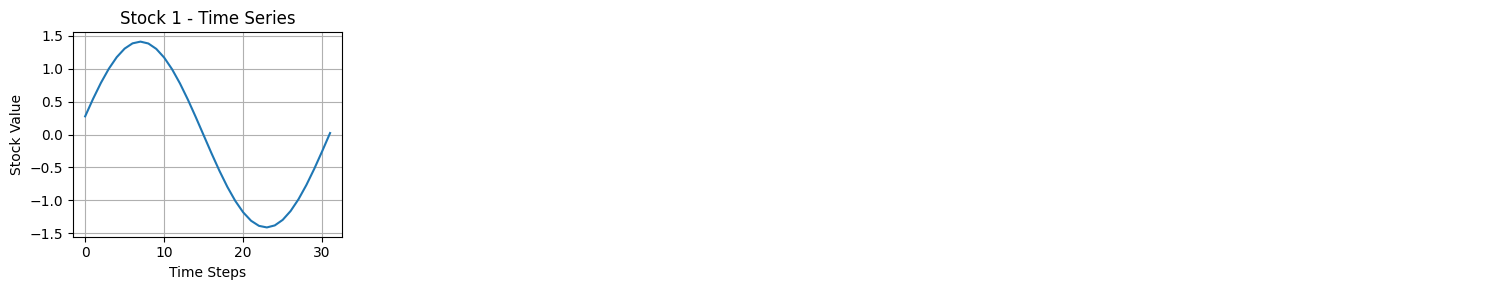

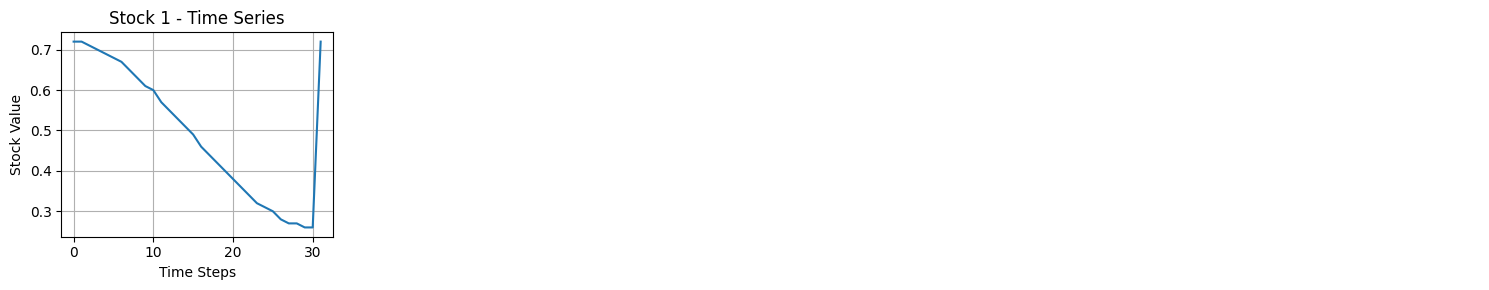

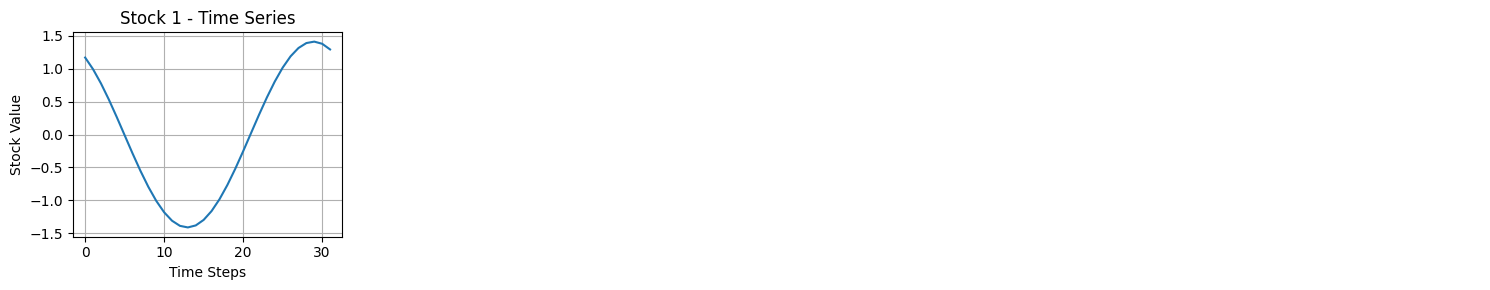

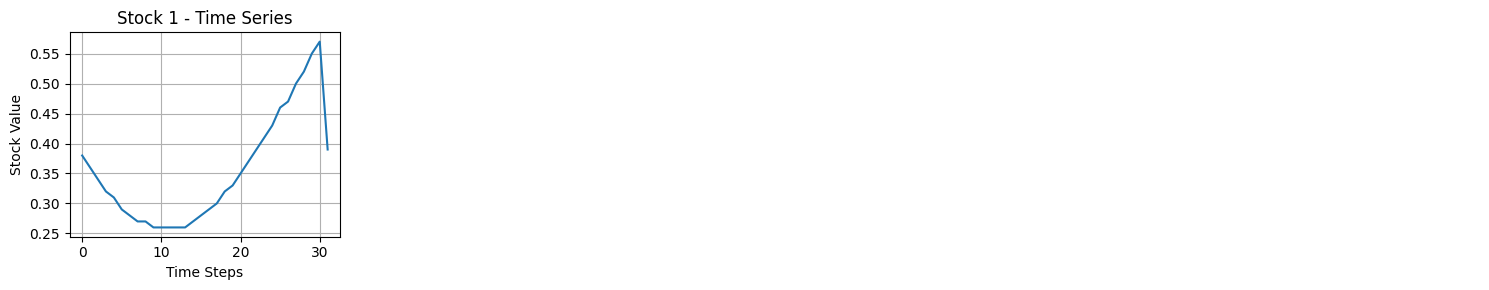

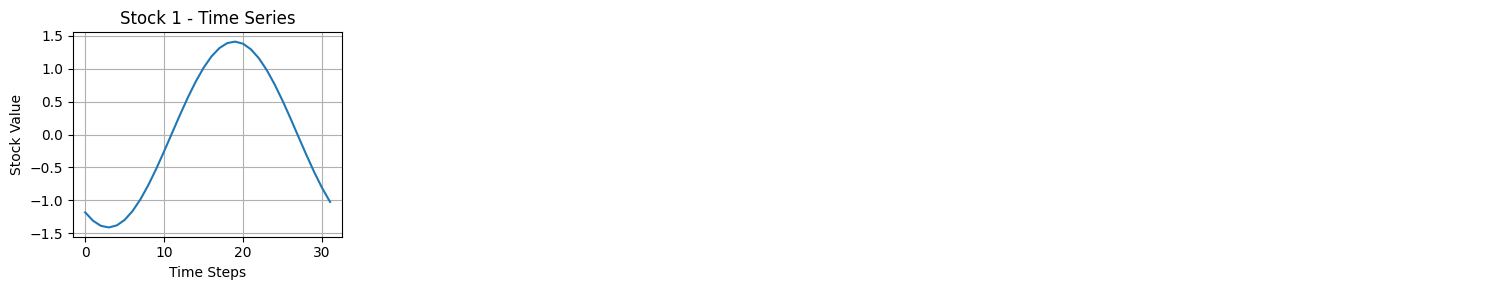

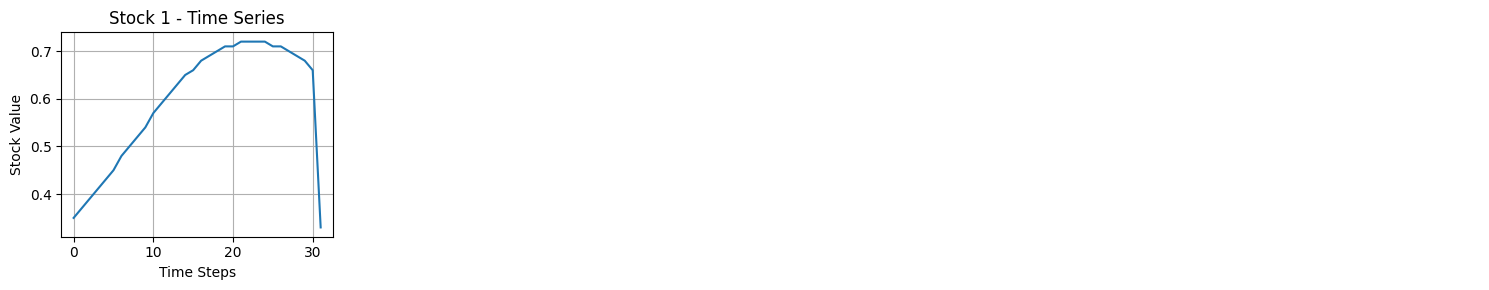

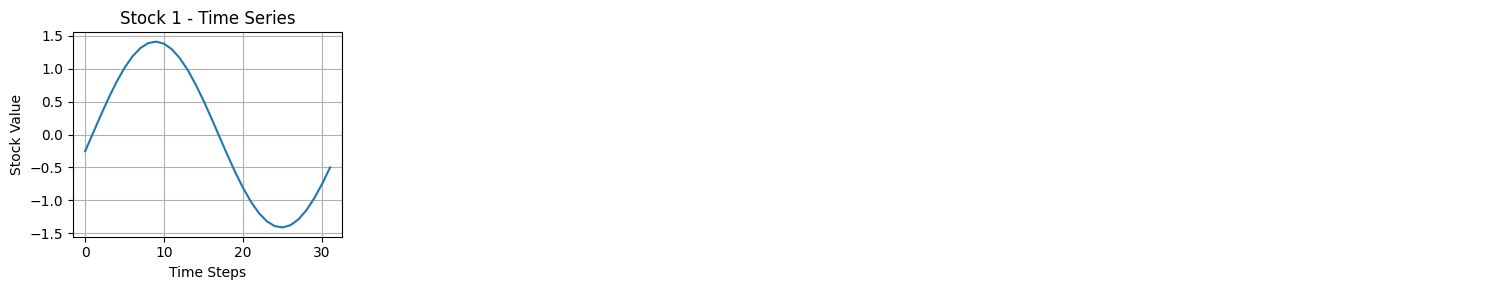

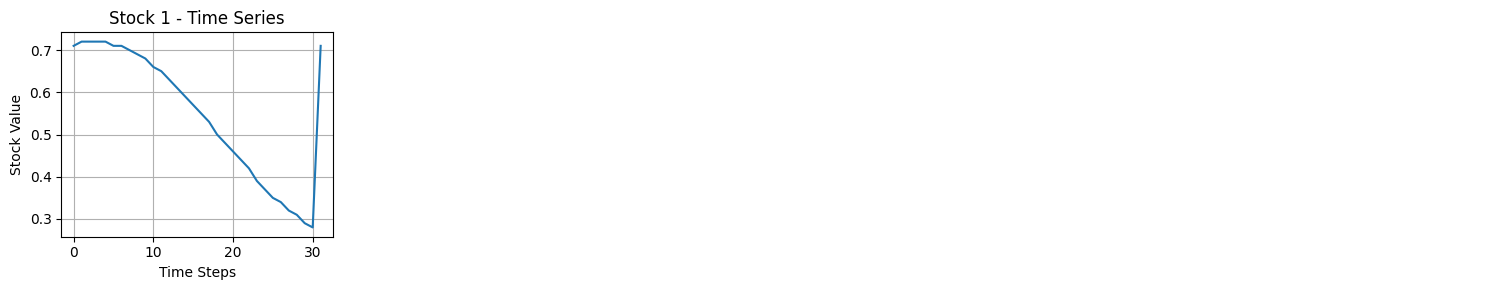

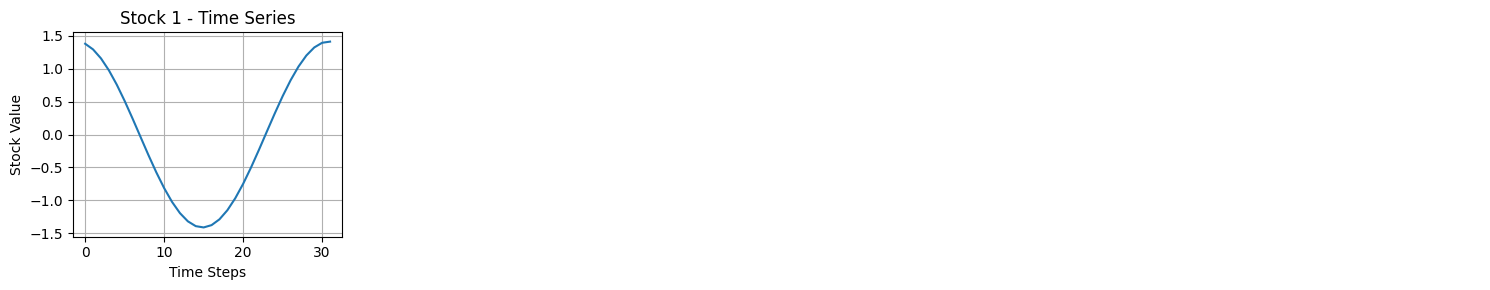

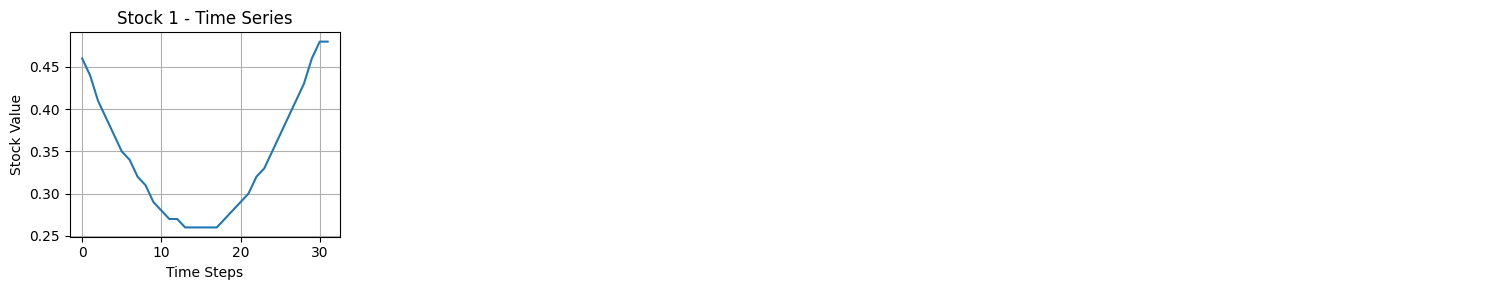

In [114]:
for i in range(0, 5):
    sh = 10 * i
    stock = 0

    stock_shift = stock * pred_ahead
    
    context = inp_clean_data[sh:1+sh, :]
    context = context.reshape((1, context.shape[0], context.shape[1]))
    
    out = trainer1.gen(context)

    inpa = context.view(1, num_of_channels, back_window)[:,stock,:]
    plot_timeseries(inpa, num_charts=1)

    outp = out.view(1, num_of_channels, pred_ahead, -1)

    outp=torch.argmax(outp, dim=-1) / vocab_size
    
    plot_timeseries(outp[:,stock,:] , num_charts=1)
    
    # to_plot = torch.cat([inpa, outpa], dim=1)
    # plot_timeseries(to_plot, num_charts=1)

In [115]:
import torch

# Example tensor: [4735 stocks, 5283 time steps]
stocks = 1
time_steps = 6
data = torch.randn(stocks, time_steps)  # Random data for example


In [116]:
create_diff_tensor(data, 2)

tensor([[[ 2.7002, -0.2969],
         [-2.9971, -3.7174],
         [-0.7203,  1.2996],
         [ 2.0200,  2.0572]]])

In [117]:
data

tensor([[-0.6599,  2.0402, -0.9569, -1.6772,  0.3427,  0.3800]])